Ken Perry Attribution:
- originally derived from https://keras.io/examples/lstm_text_generation/ (link no longer valid)
- closest active link: https://www.tensorflow.org/text/tutorials/text_generation

In [1]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

In [2]:
import tensorflow as tf

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.0.0
Version 2, minor 0


In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [4]:
import os

MODEL_DIR = "/tmp"

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

    DRIVE_DIR="/content/gdrive/My Drive/"
    MODEL_DIR=os.path.join(DRIVE_DIR, "Colab Notebooks", "NYU", "Models")
    modelDirExists = True if os.path.isdir(MODEL_DIR) else False

    if modelDirExists:
      print("Saving checkpoints to ", MODEL_DIR)

# Standard imports

In [5]:
from __future__ import print_function
import tensorflow as tf


from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import random
import sys
import io
import os

from tensorflow.keras.utils import plot_model
import IPython



# Model specification

In [6]:
rnn_units     = 128  # 1024 in original
embedding_dim = 32 # 20   # 256 in original

BATCH_SIZE = 128 # 64 in original
stateful=False

# Get the text file
- create maps to map between characters and their integer encodings
  - from character to integer
  - from integer to character

In [7]:
files = { 'nietzsche':   { 'name' : 'https://s3.amazonaws.com/text-datasets/nietzsche.txt', 
                          'savedLoss': 1000 # 1.6866
                          }, 
          'shakespeare': { 'name': 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt',  
                          'savedLoss': 1.3656 # mixed case # 1.2059  for lower case # 1000
                          }
         }

file_key = 'nietzsche'  # 'shakespeare' #     
path = tf.keras.utils.get_file( file_key + '.txt', files[file_key]['name'])
savedLoss = files[file_key]['savedLoss']


with io.open(path, encoding='utf-8') as f:
    text = f.read()

eliminateBreaks = True
if eliminateBreaks:
    text = text.replace("\n", " ")
    
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

vocab_size = len(chars)

corpus length: 600893
total chars: 83


# Prepare the training data: creating example sequences/targets
- example i: maxlen consecutive characters
  - text[i:i+ maxlen] training example: $x^{(i)}$
  - text[maxlen] target: $y^{(i)}$


In [8]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 80
step = 1
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('no. sequences:', len(sentences))



nb sequences: 600813


# Truncated Back Propagation Thru Time (BPTT)

Arrange consecutive batches
- so that each row in the batches spans BATCH_SIZE characters
- the same row number in consecutive batches represents contiguous text. 
- Consider
    - row $i$
    - batches $b, (b+1)$
    - batch $b$, row $i$
        - spans $\text{ text[ b*BATCH_SIZE : (b+1)*BATCH_SIZE ] }$
    - batch $b+1$, row $i$
        - spans $\text{ text[ ( (b+1)*BATCH_SIZE) : (b+2)*BATCH_SIZE+ ]  }$
- Require BATCH_SIZE == maxlen

In [10]:
BATCH_SIZE = maxlen

seq_len = len(text)
num_batches = seq_len // BATCH_SIZE

sentences_b, next_chars_b = [], []

for batch_num in range(0, num_batches):
    # Batch begins at bstart = batch_num * BATCH_SIZE
    # Row i is the text spanning text[bstart +  i : bstart + BATCH_SIZE]
    #  - Each row spans BATCH_SIZE characters start at bstart + i
    #  - The corresponding row i in the subsequent batch is offset by BATCH_SIZE from (bstart + i)
    #  - Thus, row i across batches is a continguous block of text
    bstart = batch_num * BATCH_SIZE
    
    for i in range(0, BATCH_SIZE):
        sentences_b.append( text[bstart: bstart + BATCH_SIZE] )
        next_chars_b.append( text[bstart + BATCH_SIZE])

In [15]:
print('no. batched sequences:', len(sentences_b))


no. batched sequences: 600880


In [14]:
i = 10
print("Row i across 3 consecutive batches, shown one batch at a time")
print("\n\t", sentences_b[i], "\n\t", sentences_b[i+BATCH_SIZE], "\n\t", sentences_b[i+2*BATCH_SIZE])
print("Shown concatentated:")
print("\n\t", sentences_b[i] + sentences_b[i+BATCH_SIZE] + sentences_b[i+2 * BATCH_SIZE])

Row i across 3 consecutive batches, shown one batch at a time

	 PREFACE   SUPPOSING that Truth is a woman--what then? Is there not ground for su 
	 specting that all philosophers, in so far as they have been dogmatists, have fai 
	 led to understand women--that the terrible seriousness and clumsy importunity wi
Shown concatentated:

	 PREFACE   SUPPOSING that Truth is a woman--what then? Is there not ground for suspecting that all philosophers, in so far as they have been dogmatists, have failed to understand women--that the terrible seriousness and clumsy importunity wi


# Examine the prepared input: 
- x: a prefix (of length maxlen)
- y: the following character

In [190]:
pad = len(sentences[0]) // 2
print(" i " +  " " * pad + "x" + " " * pad + "         " + "y")
print("   " +  "_" * pad + "_" + "_" * pad + "_________" + "_")


    
for i, example in enumerate( zip(sentences, next_chars)):
  if i > 9: break
  else: pass
  (sentence, next_char) = example
  print("[{i:d}]\t{sent:s}  |  {targ:s}".format(i=i, sent=sentence.replace("\n", " "), targ=next_char))

 i                                         x                                                 y
   ___________________________________________________________________________________________
[0]	PREFACE   SUPPOSING that Truth is a woman--what then? Is there not ground for su  |  s
[1]	FACE   SUPPOSING that Truth is a woman--what then? Is there not ground for suspe  |  c
[2]	E   SUPPOSING that Truth is a woman--what then? Is there not ground for suspecti  |  n
[3]	 SUPPOSING that Truth is a woman--what then? Is there not ground for suspecting   |  t
[4]	PPOSING that Truth is a woman--what then? Is there not ground for suspecting tha  |  t
[5]	SING that Truth is a woman--what then? Is there not ground for suspecting that a  |  l
[6]	G that Truth is a woman--what then? Is there not ground for suspecting that all   |  p
[7]	hat Truth is a woman--what then? Is there not ground for suspecting that all phi  |  l
[8]	 Truth is a woman--what then? Is there not ground for suspecting that all phil

# Prepare the input
- Preparation differs depending on whether the first layer of the model is Embedding
  - if it is: No need to OHE.  Embedding takes integers as input
  - it it is NOT: OHE the input 
    - For example $i$: only encode $x^{(i)}$
    - $y^{(i)}$ can remain an integer if you change the loss type to "sparse_categorical.." from "categorical.."

In [191]:
def OHE(sentences, maxlen, vocab_size, Debug=False):
  if Debug:
   print('Vectorization...')

  x = np.zeros((len(sentences), maxlen, vocab_size), dtype=bool)
  # y = np.zeros((len(sentences), len(chars)), dtype=bool)
  y = np.zeros(len(sentences))
 
  for i, sentence in enumerate(sentences):
      for t, char in enumerate(sentence):
          x[i, t, char_indices[char]] = 1
      # Don't need to OHE target if loss type is "sparse_categorical..." rather than "categorical.."
      # y[i, char_indices[next_chars[i]]] = 1
      y[i] = char_indices[next_chars[i]]

  return x, y

def embedding_prep(sentences, maxlen, vocab_size, Debug=False):
  if Debug:
   print("Prepare for Embedding as first layer...")
   
  x = np.zeros( (len(sentences), maxlen) )
  y = np.zeros(len(sentences))

  for i, sentence in enumerate(sentences):
      for t, char in enumerate(sentence):
          x[i, t] = char_indices[char]
      y[i] = char_indices[next_chars[i]]

  return x, y

if embedding_dim is None:
  x,  y = OHE(sentences, maxlen, vocab_size)
else:
  x, y = embedding_prep(sentences, maxlen, vocab_size)


# Examine the input shape
- $x^{(i)}_{(t),j}$ is found at  $x[ i, t, j ]$

  - example i
  - time step/sequence element t
  - a sequence element is a vector, index at position j
    - length of OHE (number of distinct characters)

In [192]:
print("X shape: ", x.shape)
print("\tNumber of examples: ", x.shape[0])
print("\tEach example is sequence of length ", x.shape[1])

if len(x.shape) > 2:
  print("\tEach element of the sequence is of length ", x.shape[2])
else:
  print("\tEach element of the sequence is a scalar")

X shape:  (200271, 80)
	Number of examples:  200271
	Each example is sequence of length  80
	Each element of the sequence is a scalar


# Utility routines

The sample routine
- takes the probability vector (one probability per potential next character)
- uses it to randomly sample the next character to produce
- `temperature`
  - our model produces a probability from a score, using the softmax, as usual for Classifiers that we have studied
  - softmax exagerates small differences in the score into larger differences in probability
  - the `temperature` controls the degree of exageration
- the routine recalculates the probability, using the desired temperature before sampling



In [193]:
def createModel(vocab_size, rnn_units, embedding_dim=None, stateful=False):
  model = Sequential()
  if embedding_dim is not None:
    print("\nWARNING: First layer is Embedding. Input SHOULD NOT be OHE ! Input to Embedding is integer, note OHE vector\n")
    model.add( Embedding(vocab_size, embedding_dim, input_length=maxlen)  )
    model.add(LSTM(rnn_units, stateful=stateful))
  else:
    model.add(LSTM(rnn_units, input_shape=(maxlen, vocab_size), stateful=stateful) )

  model.add(Dense(vocab_size, activation='softmax'))

  return model

def plotModel(model, modelName):
  plotFile = modelName + ".png"
  plot_model(model, plotFile, show_shapes=True)

  return plotFile
  
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    diversities = [0.2, 0.5, 1.0, 1.2]
    for diversity in diversities[:2]:
        # print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('\n----- Generating with seed (diversity={d:3.2f}): "{sent:s}"\n\t'.format(d=diversity, sent=sentence) )
        sys.stdout.write(generated)

        # Generate some text, based on the currently constructed sentence
        len_to_generate = 400
        for i in range(len_to_generate):
            # Encode the characters of sentence as OHE vectors over the set of characters chars
            old = False
            if old:
              if embedding_dim is None:
                x_pred = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(sentence):
                    # One Hot Encode word t of sentence
                    x_pred[0, t, char_indices[char]] = 1.
              else:
                x_pred = np.zeros( (1, maxlen) )
                for t, char in enumerate(sentence):
                  x_pred[0, t] = char_indices[char]
            else:
              if embedding_dim is None:
                x_pred, _ = OHE( [ sentence ], maxlen=maxlen, vocab_size=vocab_size)
              else:
                x_pred, _ = embedding_prep([ sentence ], maxlen=maxlen, vocab_size=vocab_size)

            # Predict next character
            preds = model.predict(x_pred, verbose=0)[0]

            # prediction preds is a probability vector; sample from it to get next character next_char
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            # Append next_char to sentence
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()



Build model...




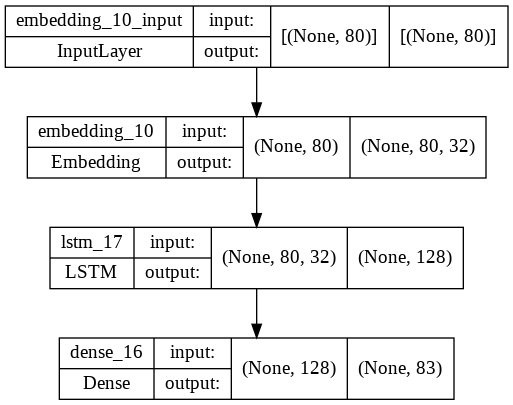

In [194]:
# build the model: a single LSTM


print('Build model...')
model = createModel(vocab_size, rnn_units, embedding_dim=embedding_dim)

optimizer = RMSprop(lr=0.01)
model.compile(loss='sparse_categorical_crossentropy') #, optimizer=optimizer)

plotFile = plotModel(model, "first_model")
IPython.display.Image(plotFile) 



# Resume training from existing weights ?
- Training takes a long time.  We can resume training from a previously stored checkpoint
- The name of the checkpoint file depends on
  - The maxlen variable (max sequence length)
  - The loss from the saved session
- To resume from a checkpoint
  - set saveLoss to be equal to the loss of the saved checkpoint

If the checkpoint file doesn't exist, training will start from scratch

In [195]:


ckpt_filepath_format=os.path.join(MODEL_DIR, "lstm_text_gen_{file_key:s}_{len:d}_-loss_".format(file_key=file_key, len=maxlen) + "{loss:.4f}.h5")
modelFile = ckpt_filepath_format.format(loss=savedLoss) # None

if modelFile is not None and os.path.exists(modelFile):
  print("Initializing with weights from ", modelFile)
  model.load_weights(modelFile)

In [196]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

ckpt_filepath=ckpt_filepath_format
checkpoint_callback = ModelCheckpoint(ckpt_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')



# Train

In [ ]:
callbacks = [print_callback]

modelDirExists = True if os.path.isdir(MODEL_DIR) else False
if modelDirExists:
  callbacks.append(checkpoint_callback)

model.fit(x, y,
          batch_size=BATCH_SIZE,
          epochs=60,
          shuffle=False,
          callbacks=callbacks)

Epoch 1/60
  29/1565 [..............................] - ETA: 6:31 - loss: 3.3038